# Project Statement

The Film Junky Union, a new edgy community for classic movie enthusiasts, is developing a system for filtering and categorizing movie reviews. The goal is to train a model to automatically detect negative reviews. You'll be using a dataset of IMBD movie reviews with polarity labelling to build a model for classifying positive and negative reviews. It will need to have an F1 score of at least 0.85.

## Initialization

In [1]:
import math

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

from tqdm.auto import tqdm

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [ ]:
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [5]:
df_reviews['ds_part'] = df_reviews['ds_part'].astype(str).str.strip()
df_reviews = df_reviews[df_reviews['ds_part'].isin(['train', 'test'])].copy()

In [6]:
df_reviews['pos'] = df_reviews['pos'].astype(int)
df_reviews = df_reviews.dropna(subset=['review', 'pos']).copy()
df_reviews = df_reviews.reset_index(drop=True)

In [7]:
df_reviews.head()

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281


In [8]:
print(df_reviews.info())
print(df_reviews['pos'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## EDA

Let's check the number of movies and reviews over years.

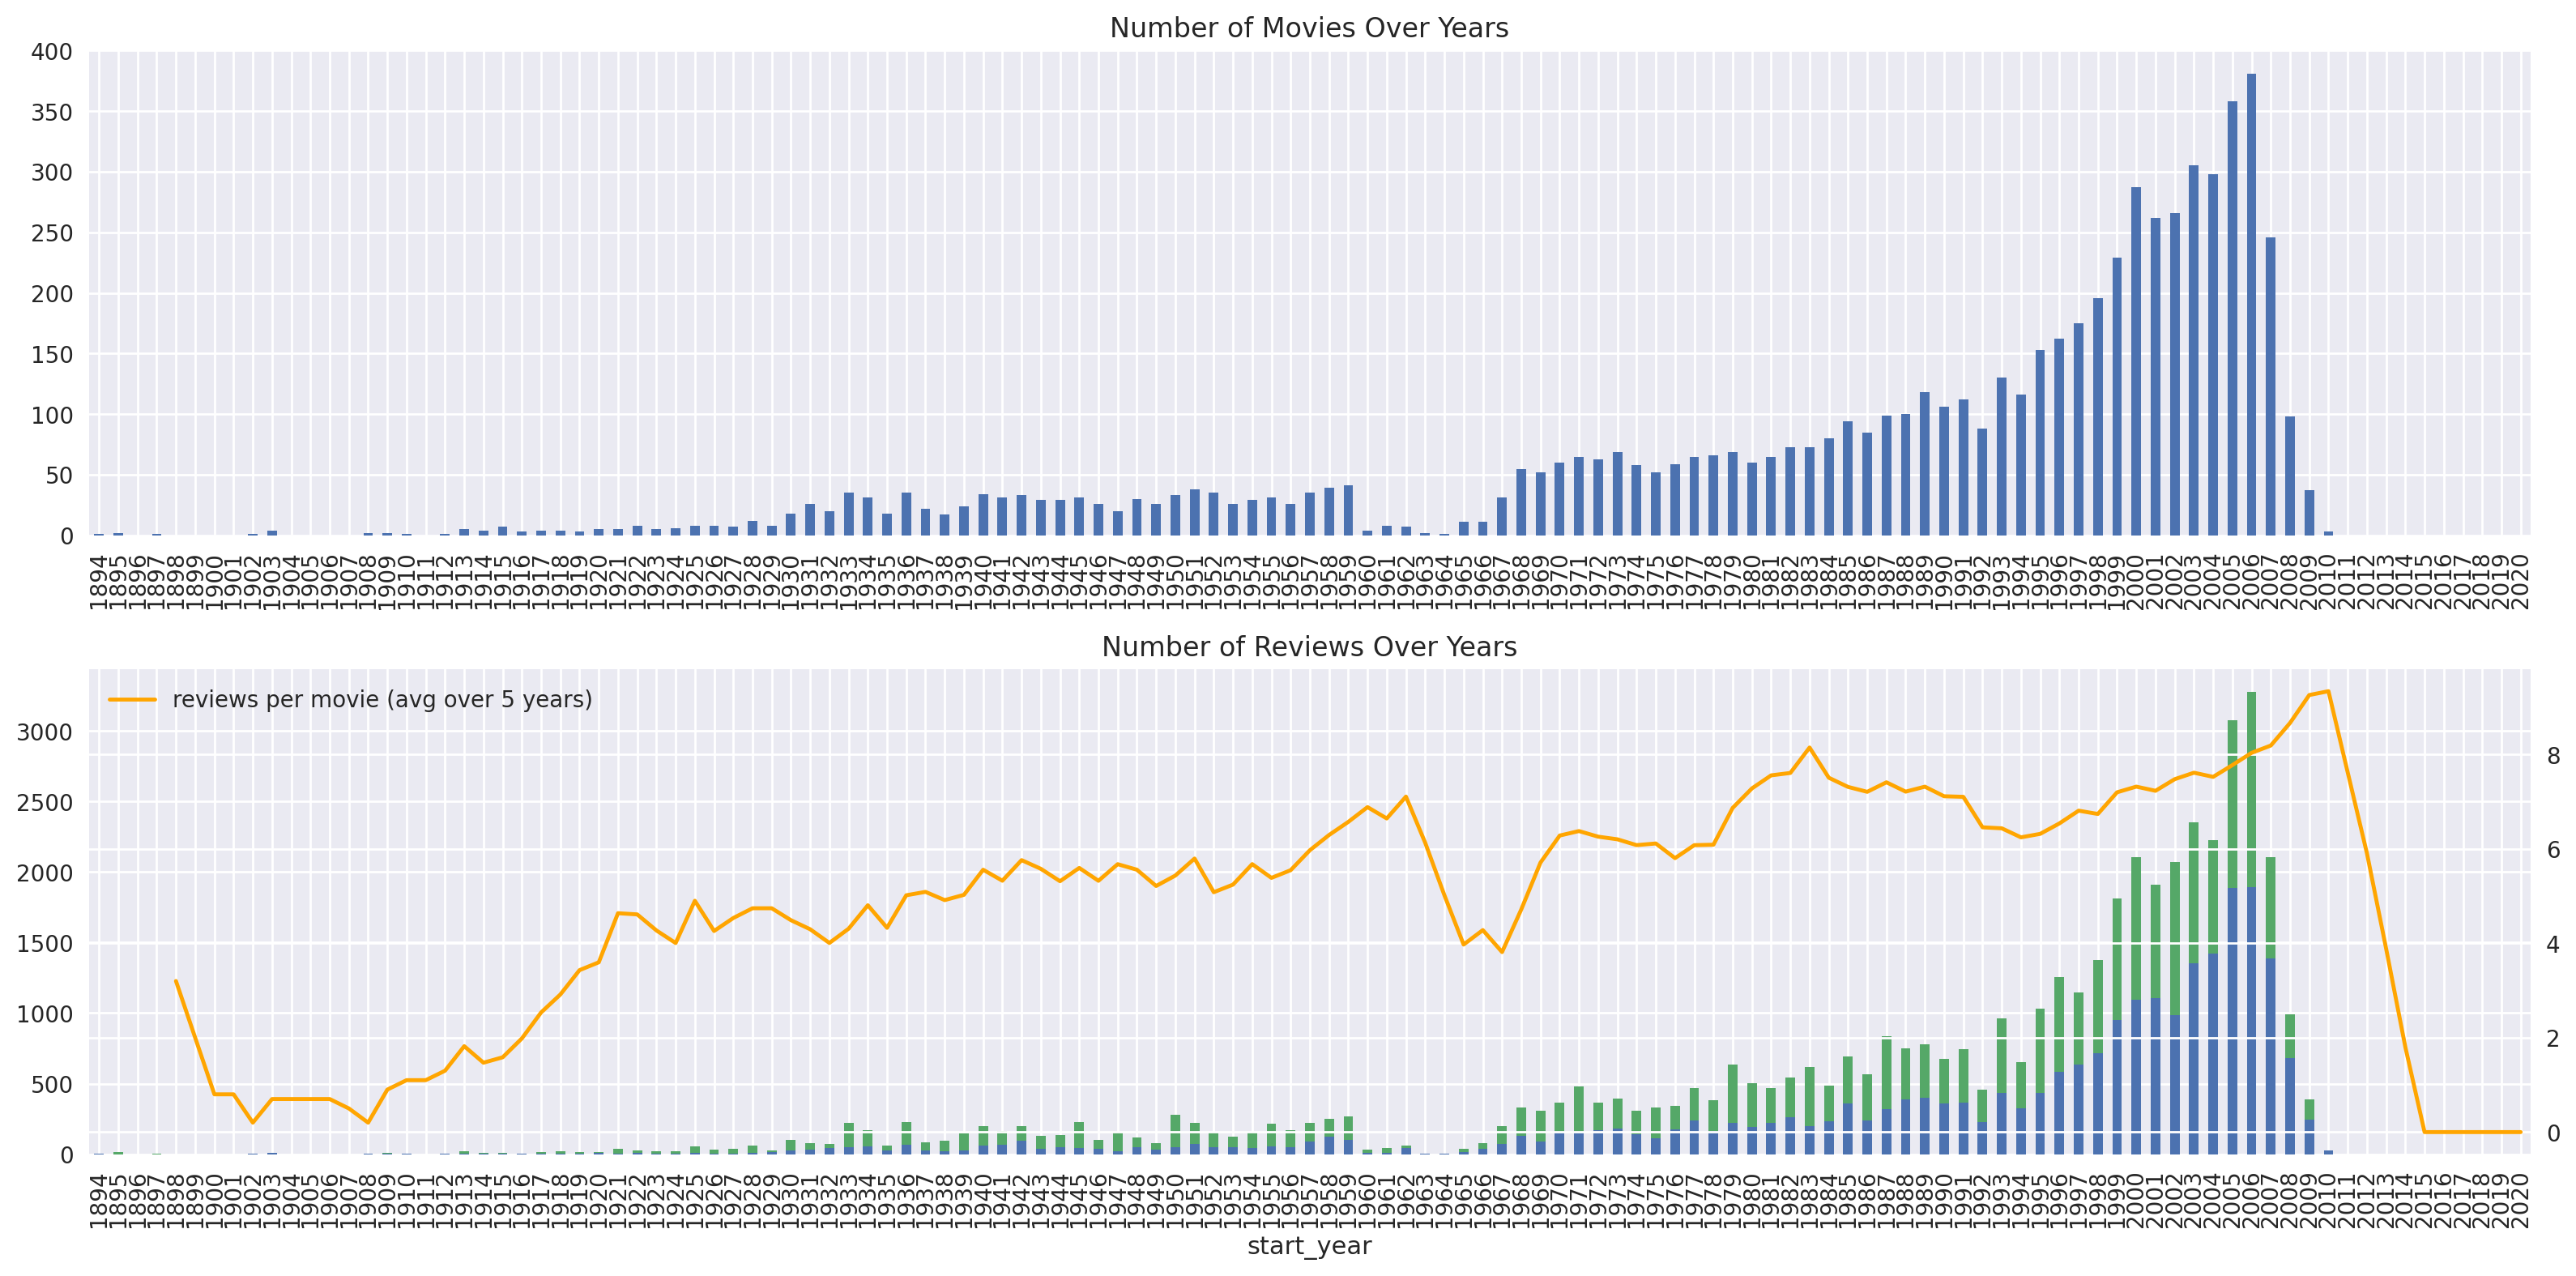

In [9]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Number of Movies Over Years')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='reviews per movie (avg over 5 years)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Number of Reviews Over Years')

fig.tight_layout()

Let's check the distribution of number of reviews per movie with the exact counting and KDE (just to learn how it may differ from the exact counting)

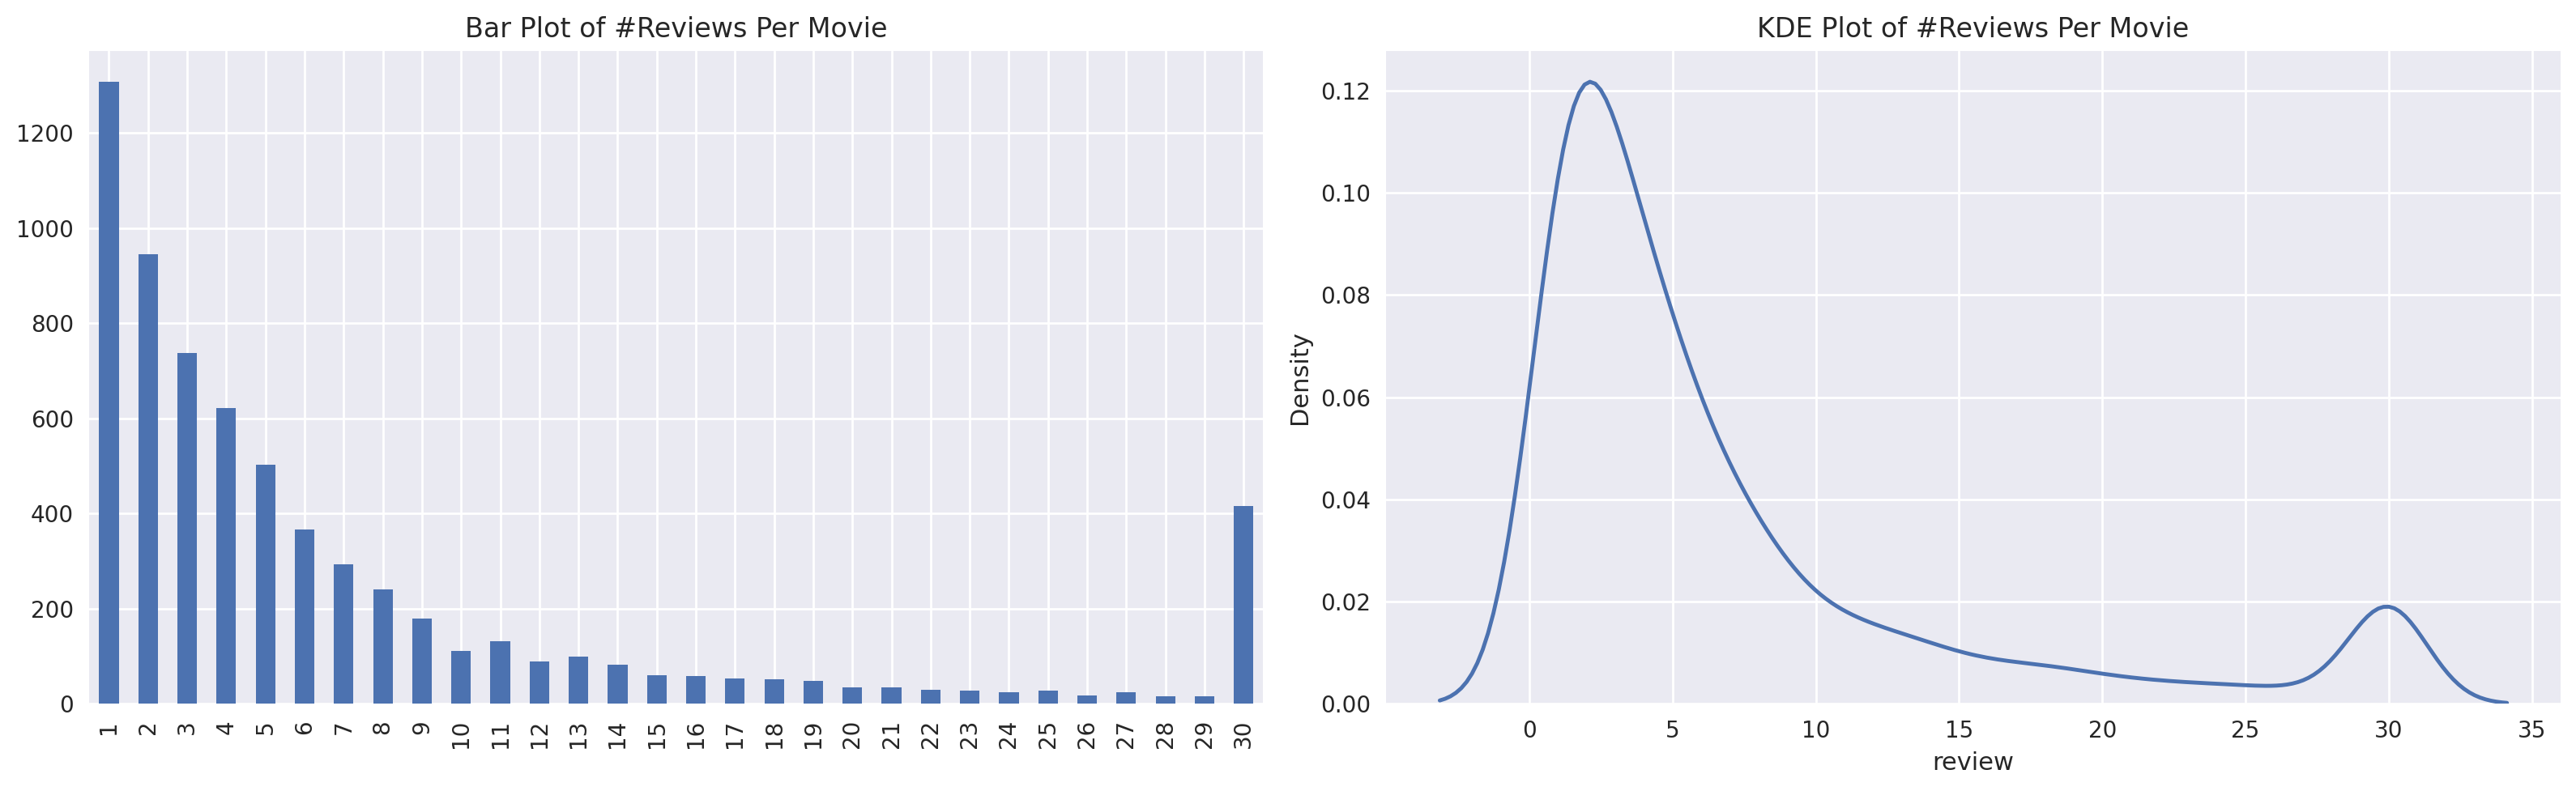

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Bar Plot of #Reviews Per Movie')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('KDE Plot of #Reviews Per Movie')

fig.tight_layout()

In [11]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

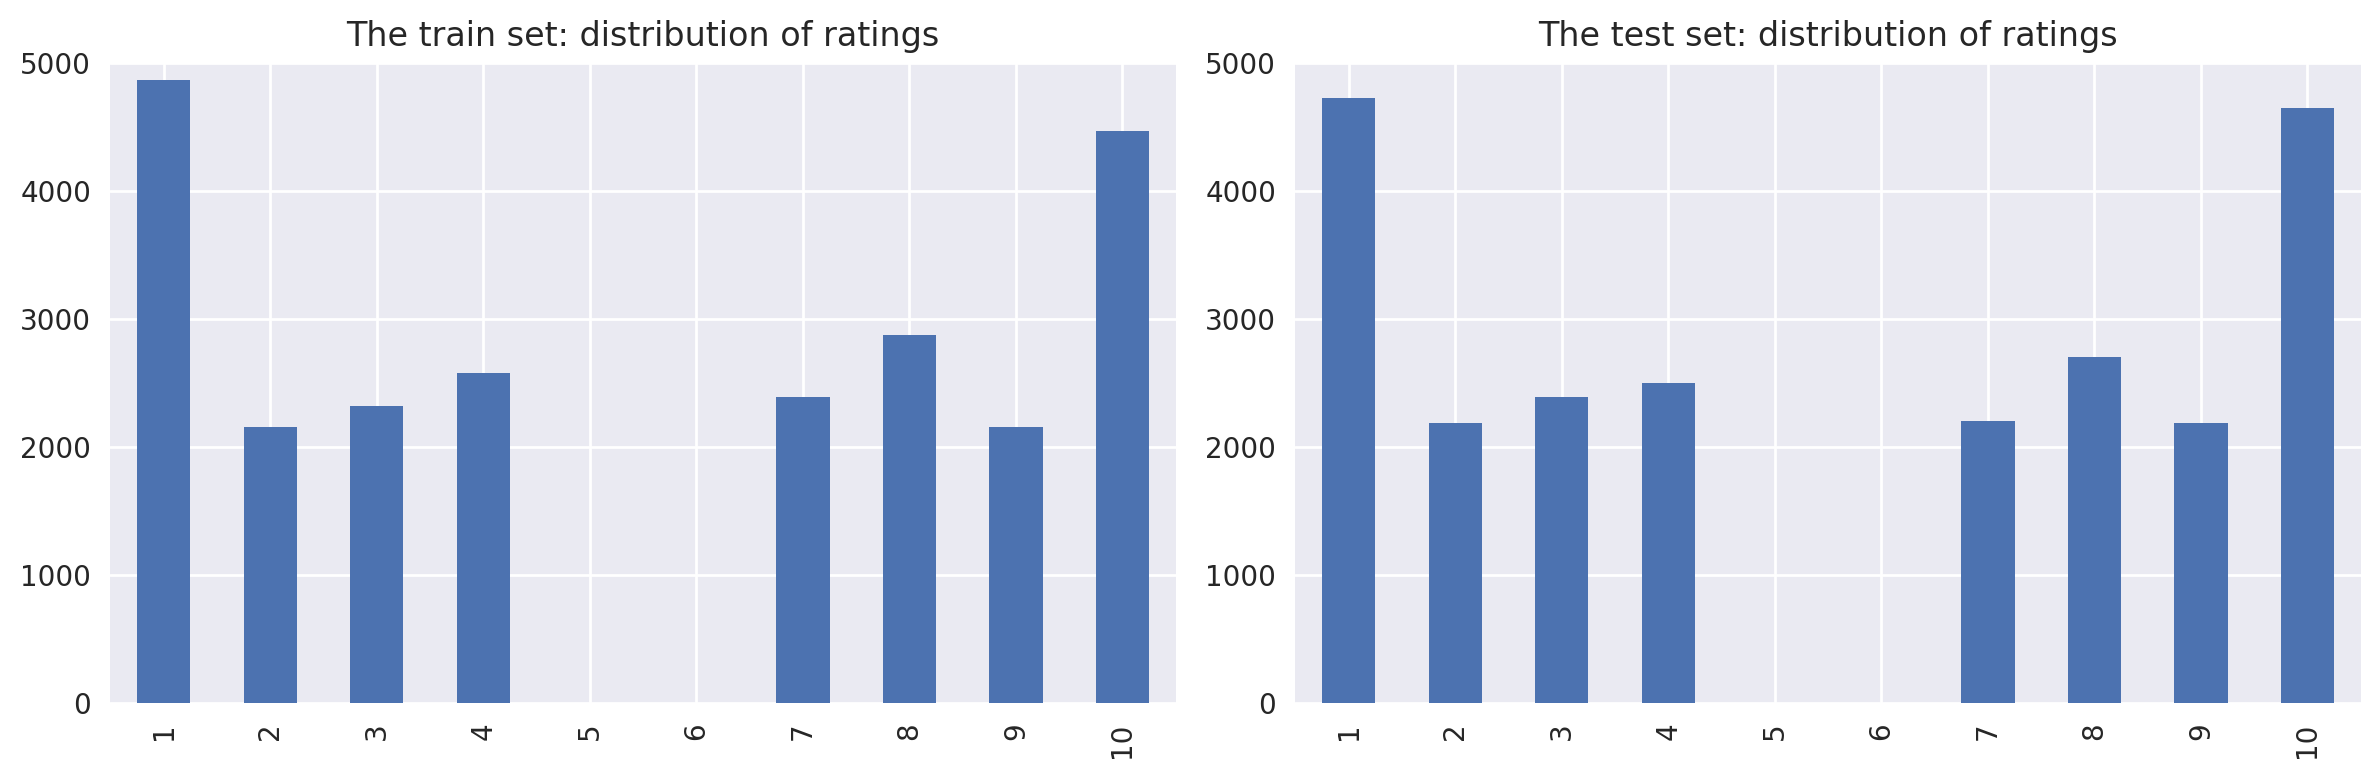

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The train set: distribution of ratings')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('The test set: distribution of ratings')

fig.tight_layout()

Distribution of negative and positive reviews over the years for two parts of the dataset

/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/.venv/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


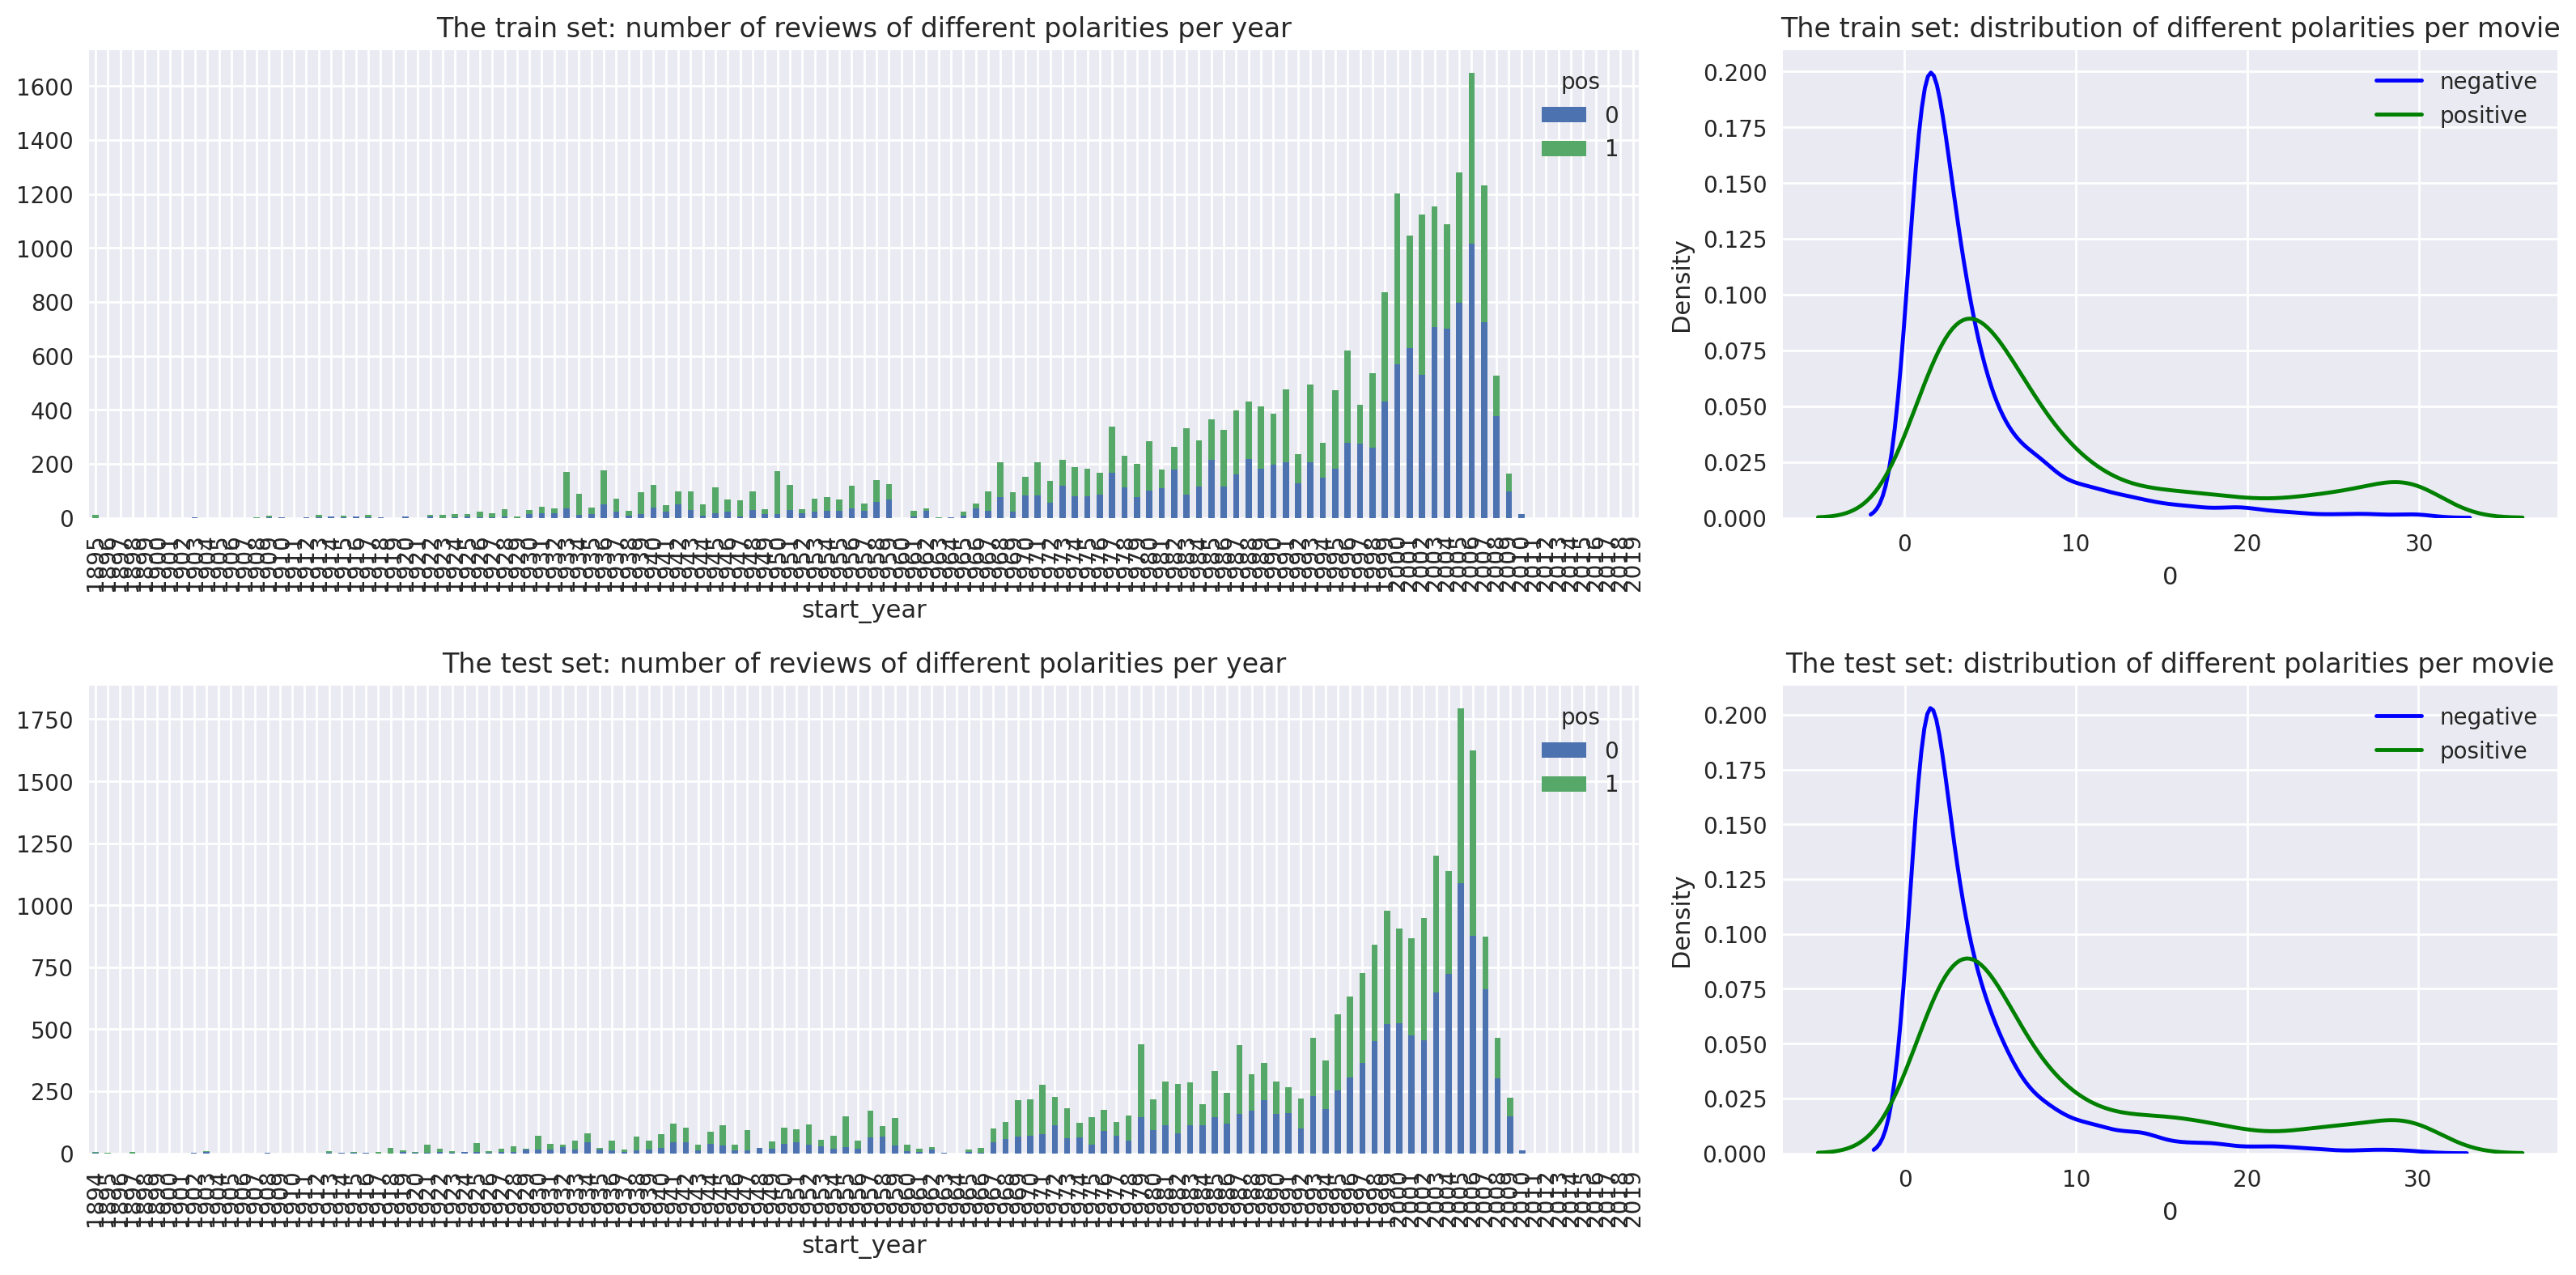

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The train set: number of reviews of different polarities per year')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The train set: distribution of different polarities per movie')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('The test set: number of reviews of different polarities per year')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

## Evaluation Procedure

Composing an evaluation routine which can be used for all models in this project

In [14]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # F1 Score
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'F1 Score') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'ROC Curve')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Accuracy', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume all models below accepts texts in lowercase and without any digits, punctuations marks etc.

In [15]:
import re

def normalize_text(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r'[^a-z/s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text
    
df_reviews['review_norm'] = df_reviews['review'].apply(normalize_text)

df_reviews[['review', 'review_norm']].head()

,review,review_norm
0,The pakage implies that Warren Beatty and Gold...,the pakage implies that warren beatty and gold...
1,How the hell did they get this made?! Presenti...,how the hell did they get this made presenting...
2,There is no real story the film seems more lik...,there is no real story the film seems more lik...
3,Um .... a serious film about troubled teens in...,um a serious film about troubled teens in sing...
4,I'm totally agree with GarryJohal from Singapo...,i m totally agree with garryjohal from singapo...


## Train / Test Split

Luckily, the whole dataset is already divided into train/test one parts. The corresponding flag is 'ds_part'.

In [16]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


<div class="alert alert-info"; style="border-left: 7px solid blue">

#### Class imbalance conclusion

The pos target is approximately balanced between 0 (negative) and 1 (positive) in both the train and test parts of the dataset. There is no severe class imbalance, so we don’t need special balancing techniques (like resampling). Standard classifiers with default or light regularization and the usual F1 metric are appropriate.

## Working with models

### Model 0 - Constant

In [17]:
from sklearn.dummy import DummyClassifier

In [18]:
train_features_0 = np.zeros((df_reviews_train.shape[0], 1))
test_features_0 = np.zeros((df_reviews_test.shape[0], 1))

In [19]:
model_0 = DummyClassifier(strategy = 'most_frequent', random_state =42)
model_0.fit(train_features_0, train_target)

DummyClassifier(random_state=42, strategy='most_frequent')

Baseline constant model(Model 0)
          train  test
Accuracy    0.5   0.5
F1          0.0   0.0
APS         0.5   0.5
ROC AUC     0.5   0.5


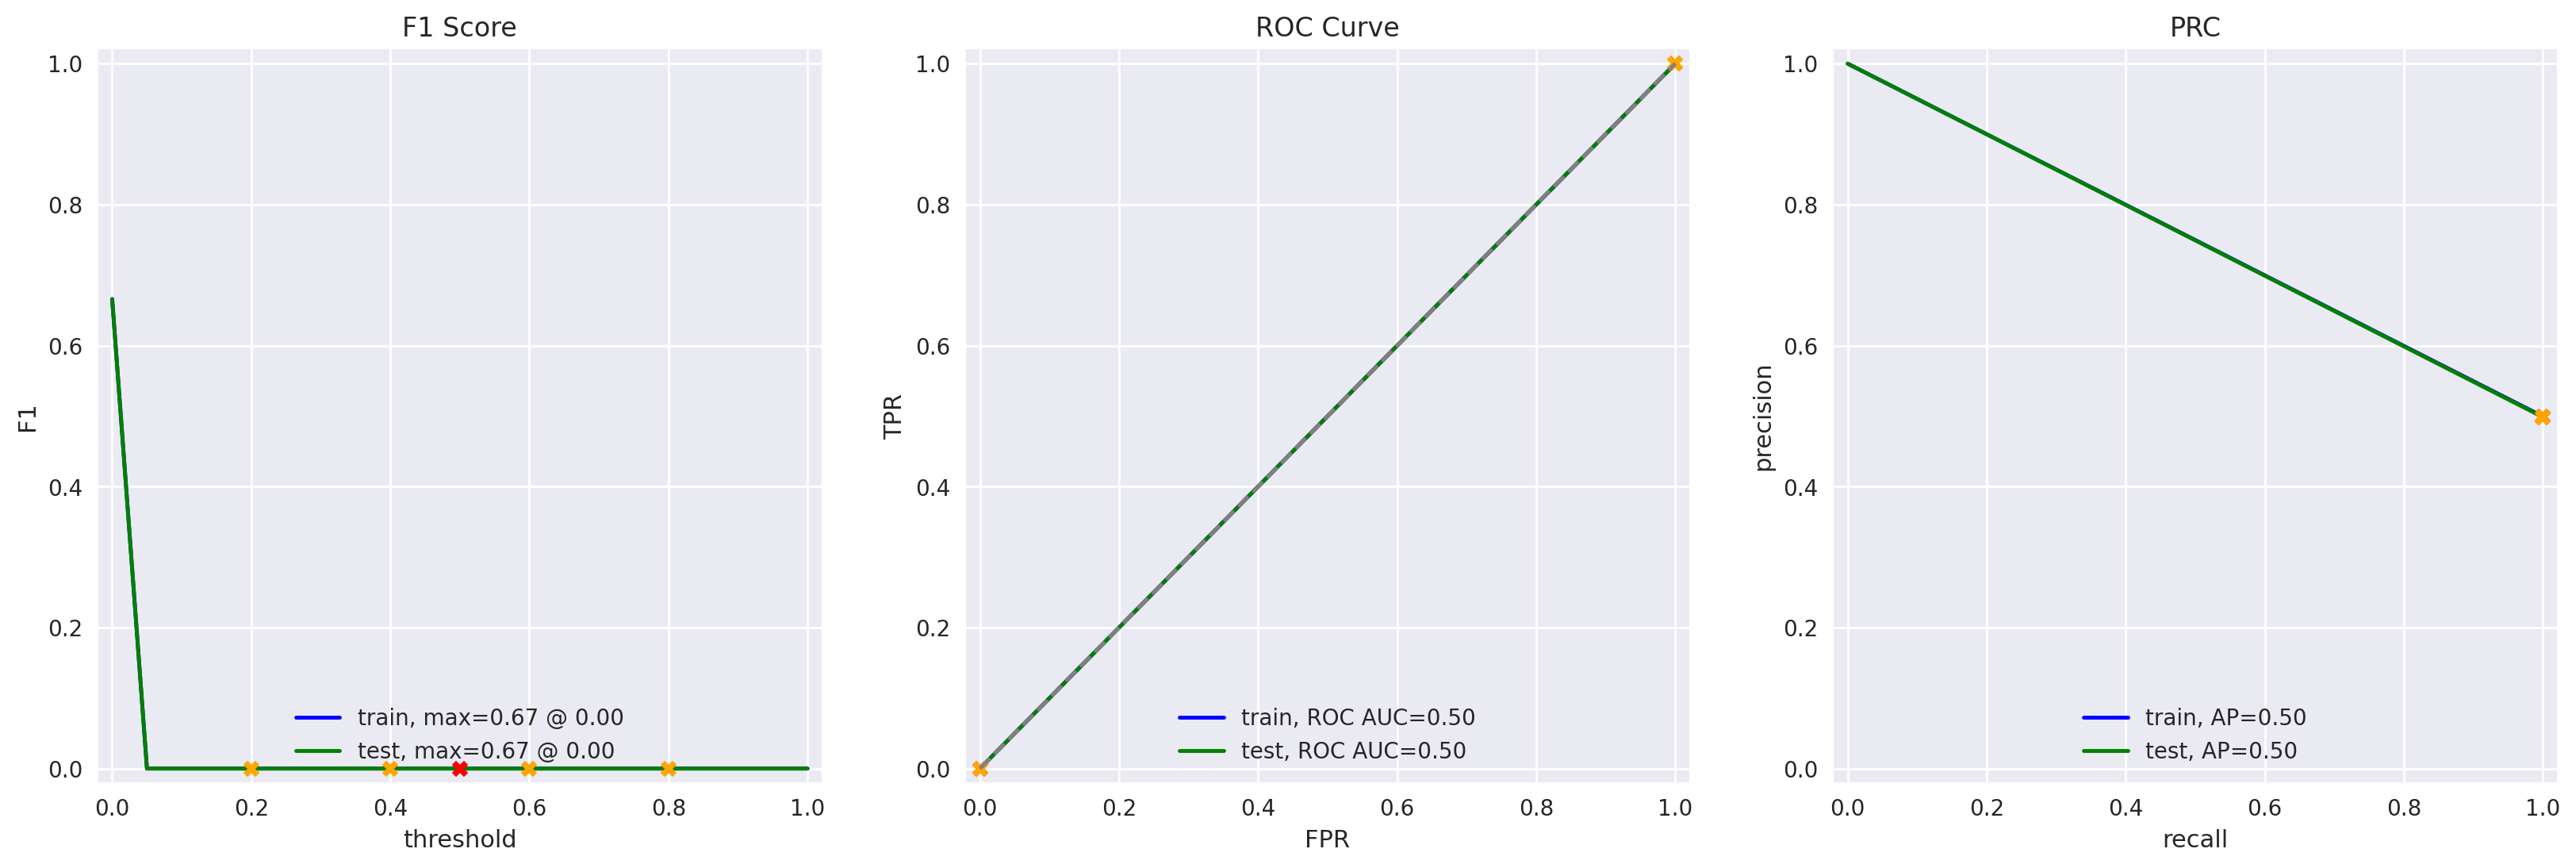

In [20]:
print("Baseline constant model(Model 0)")
evaluate_model(model_0, train_features_0, train_target, test_features_0, test_target)

### Model 1 - NLTK, TF-IDF and LR

TF-IDF

In [4]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [22]:
nltk.download('stopwords')
stop_words = stopwords.words('english')

tfidf_vectorizer_1 = TfidfVectorizer(max_features = 50000, ngram_range=(1,2), stop_words=stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/student/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
train_features_1 = tfidf_vectorizer_1.fit_transform(df_reviews_train['review_norm'])
test_features_1 = tfidf_vectorizer_1.transform(df_reviews_test['review_norm'])

model_1 = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=-1)

model_1.fit(train_features_1, train_target)

LogisticRegression(max_iter=1000, n_jobs=-1)

Model 1 - NLTK Stopwords + TF-IDF (1-2 grams) + Logistic Regression
          train  test
Accuracy   0.94  0.89
F1         0.94  0.89
APS        0.99  0.95
ROC AUC    0.99  0.96


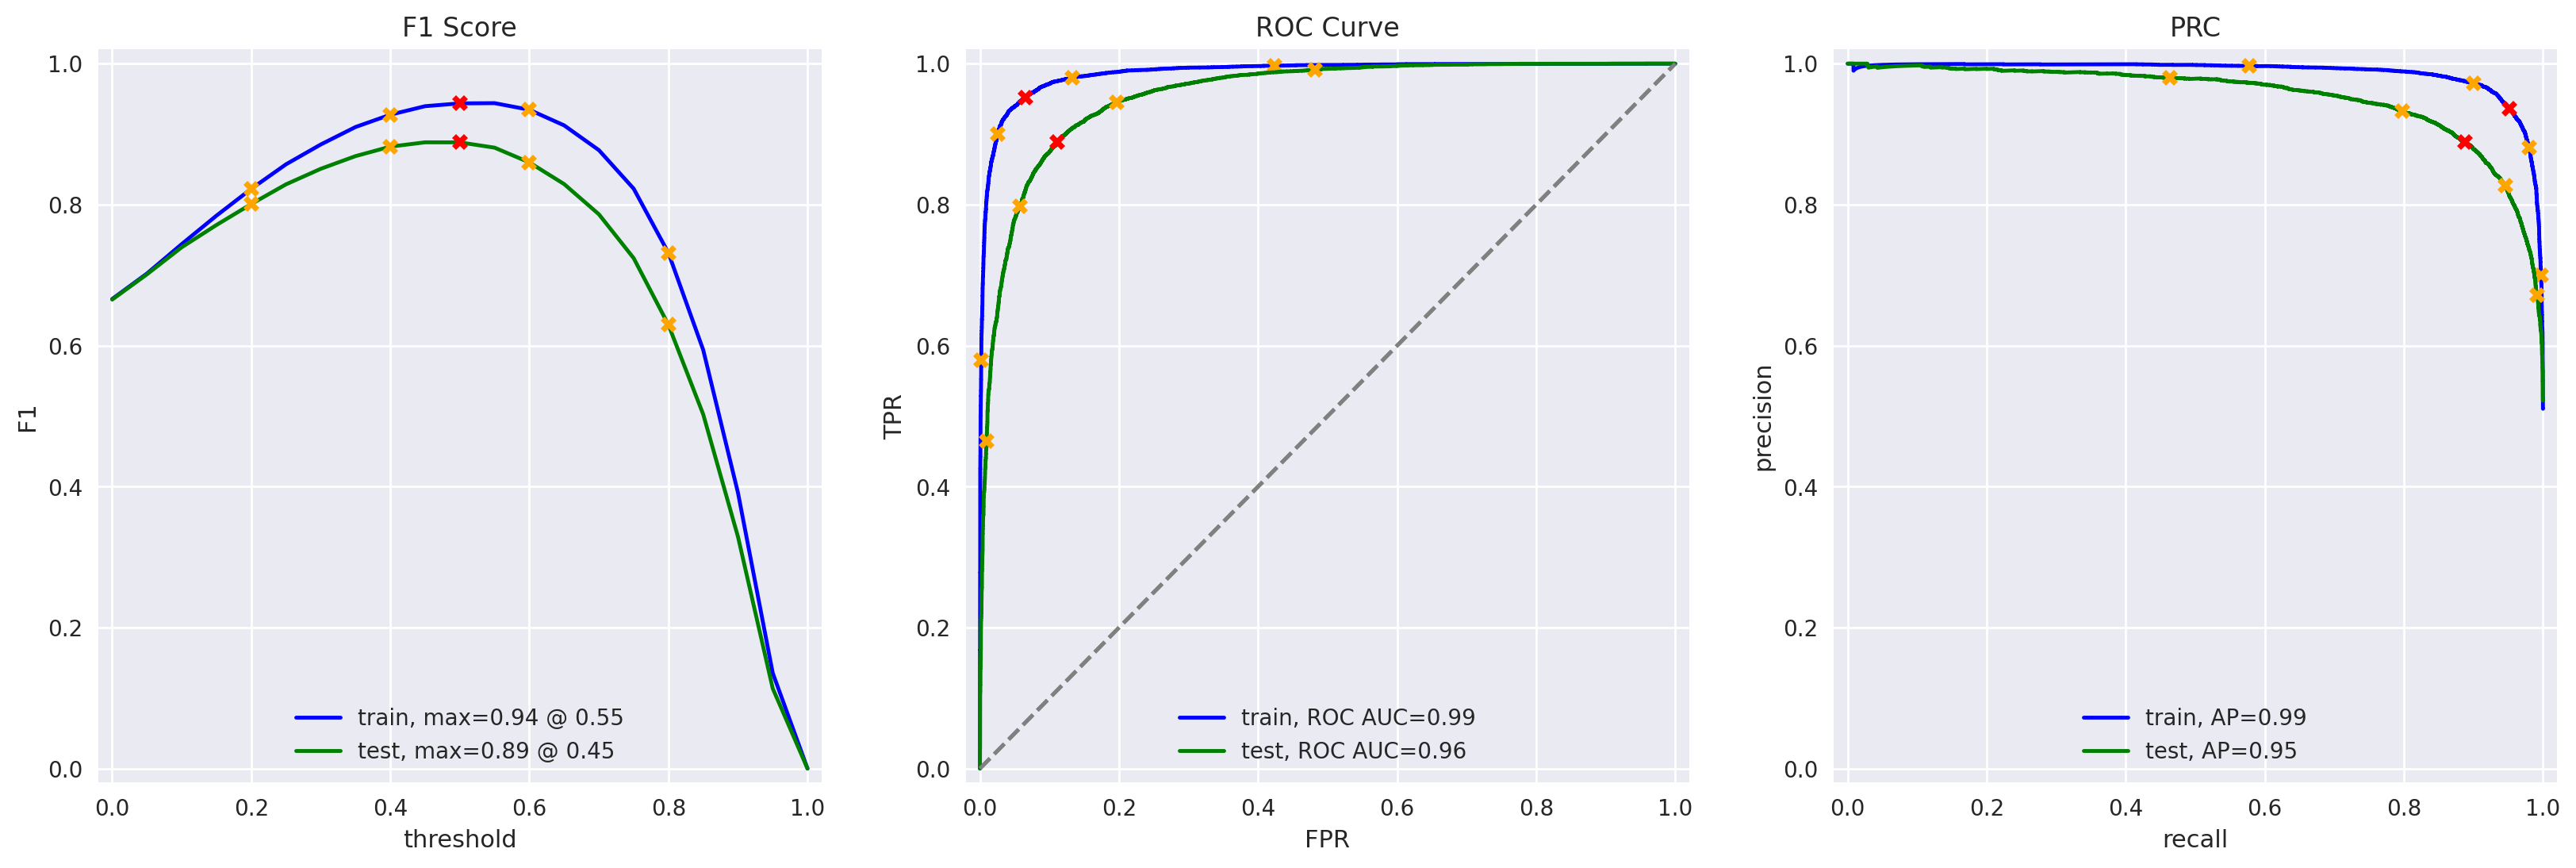

In [24]:
print("Model 1 - NLTK Stopwords + TF-IDF (1-2 grams) + Logistic Regression")
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 2 -TF-IDF (char n-grams) and LR

Here we use character-level n-grams to capture subword patterns (misspellings, slang, punctuation style, elongated words, etc.) and train another Logistic Regression model.

In [25]:
tfidf_vectorizer_2 = TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=5)

train_features_2 = tfidf_vectorizer_2.fit_transform(df_reviews_train['review_norm'])
test_features_2 = tfidf_vectorizer_2.transform(df_reviews_test['review_norm'])

In [26]:
model_2 = LogisticRegression(max_iter=1000, solver='lbfgs',n_jobs=1)
model_2.fit(train_features_2, train_target)

LogisticRegression(max_iter=1000, n_jobs=1)

Model 2 - Char-level TF-IDF (3-5 grams) + Logistic Regression
          train  test
Accuracy   0.93  0.88
F1         0.93  0.88
APS        0.98  0.95
ROC AUC    0.98  0.95


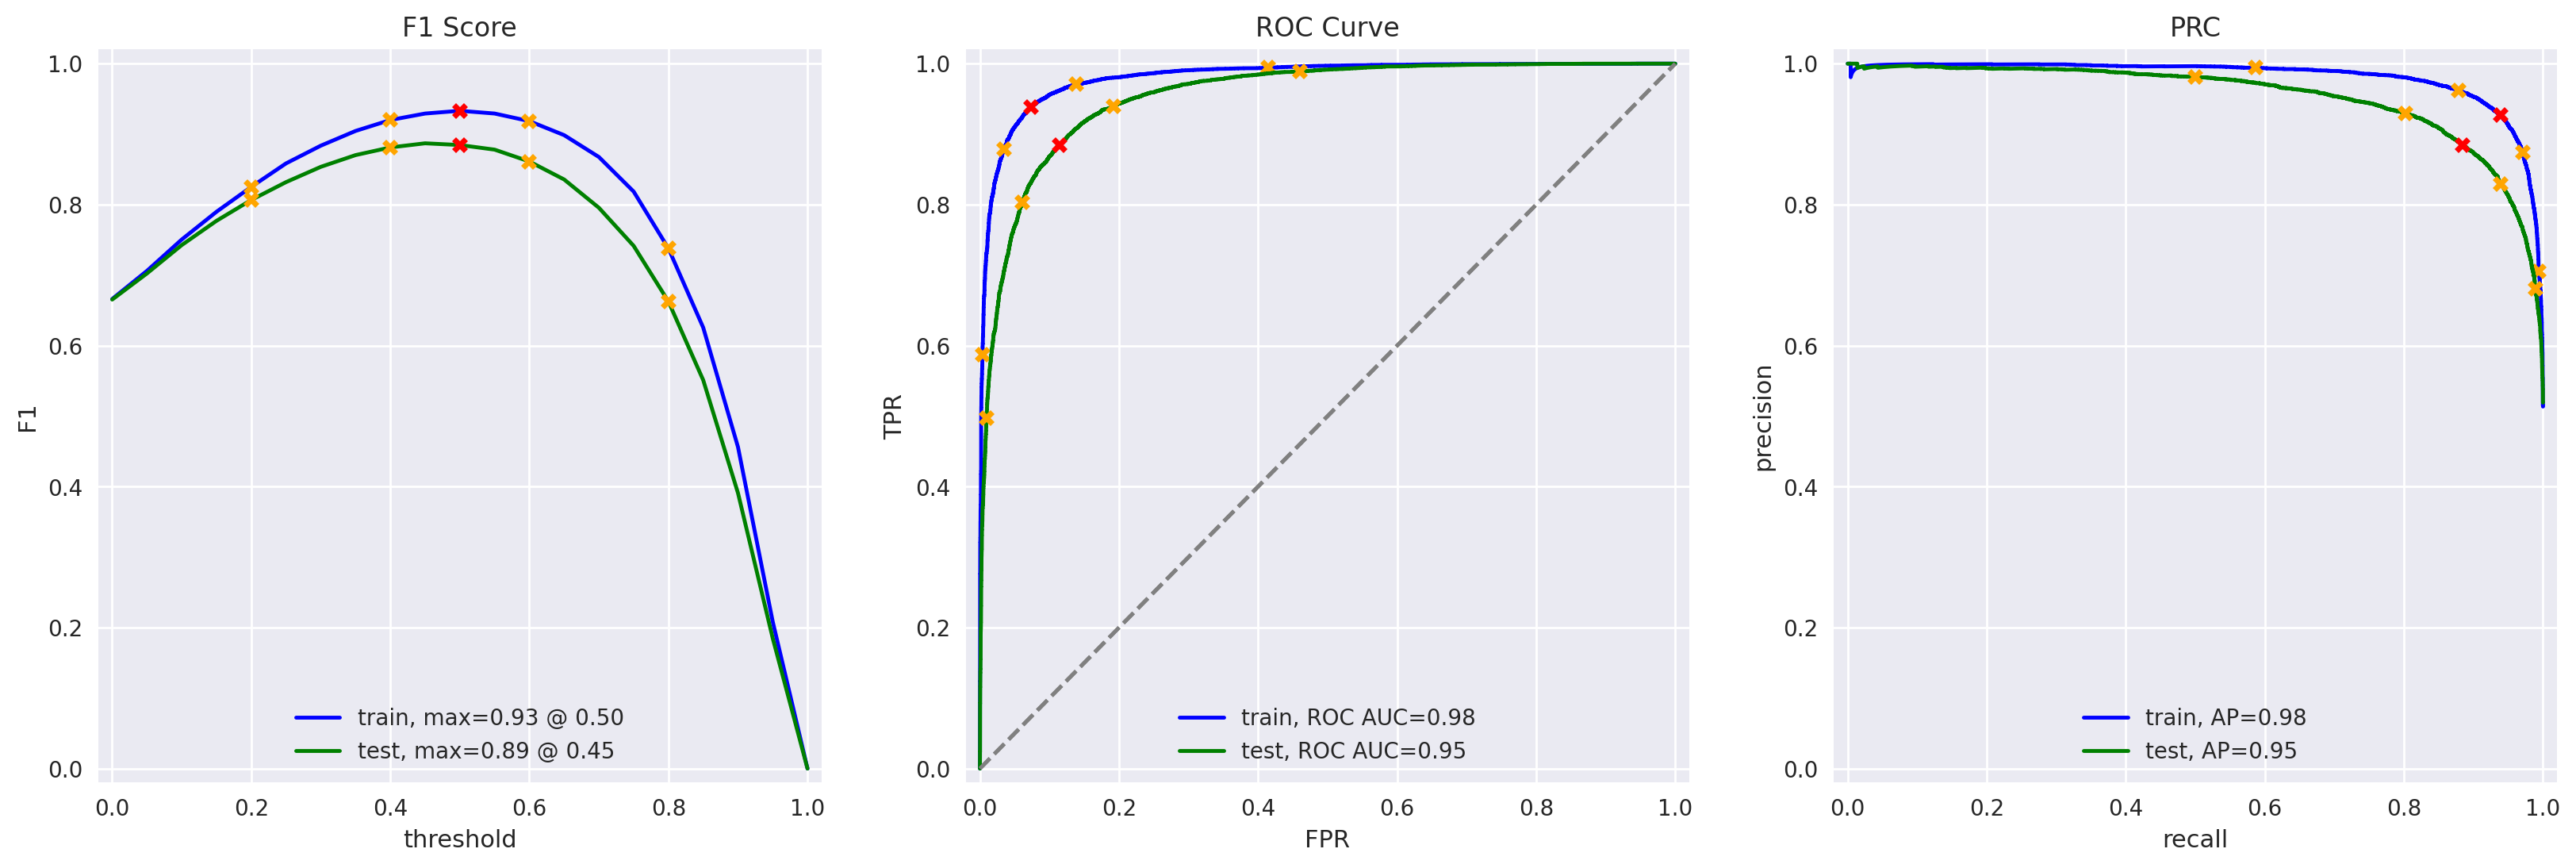

In [27]:
print("Model 2 - Char-level TF-IDF (3-5 grams) + Logistic Regression")
evaluate_model(model_2, train_features_2, train_target, test_features_2, test_target)

### Model 3 - spaCy, TF-IDF and LR

In [28]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [29]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [30]:
df_reviews_train['review_lemma'] = df_reviews_train['review_norm'].progress_apply(text_preprocessing_3)
df_reviews_test['review_lemma'] = df_reviews_test['review_norm'].progress_apply(text_preprocessing_3)

tfidf_vectorizer_3 = TfidfVectorizer(max_features = 50000, ngram_range=(1,2))

  0%|          | 0/23796 [00:00<?, ?it/s]

  0%|          | 0/23535 [00:00<?, ?it/s]

In [31]:
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_lemma'])
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_lemma'])

model_3 = LogisticRegression(max_iter=1000, solver='lbfgs', n_jobs=1)
model_3.fit(train_features_3, train_target)

LogisticRegression(max_iter=1000, n_jobs=1)

Model 3 - spaCy Lemmatization + TF-IDF (1-2 grams) + Logistic Regression
          train  test
Accuracy   0.94  0.89
F1         0.94  0.89
APS        0.99  0.96
ROC AUC    0.99  0.96


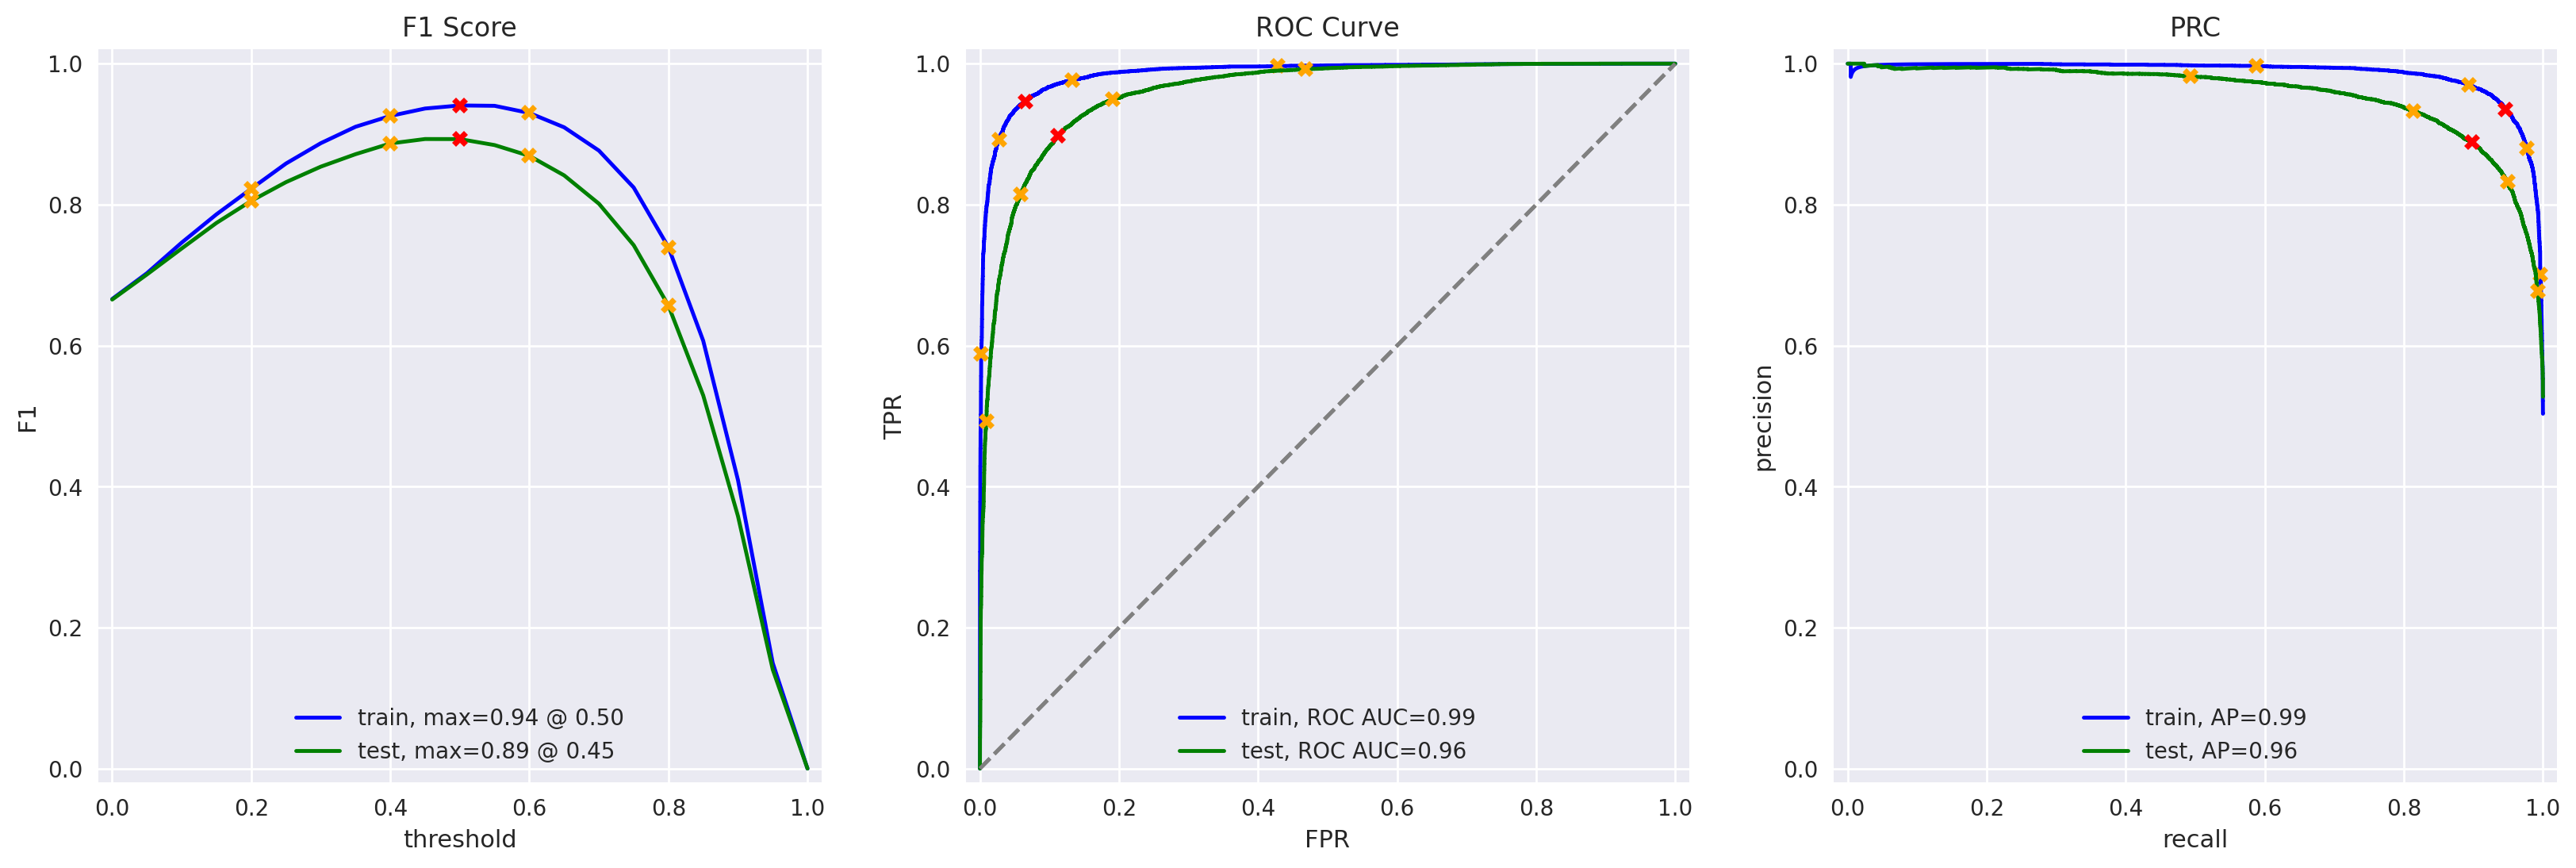

In [32]:
print("Model 3 - spaCy Lemmatization + TF-IDF (1-2 grams) + Logistic Regression")
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

### Model 4 - spaCy, TF-IDF and LGBMClassifier

In [2]:
from lightgbm import LGBMClassifier

In [ ]:
tfidf_vectorizer_4 = TfidfVectorizer(max_features=50000, ngram_range=(1,2))

train_features_4 = tfidf_vectorizer_4.fit_transform(df_reviews_train['review_lemma'])
test_features_4 = tfidf_vectorizer_4.transform(df_reviews_test['review_lemma'])

In [ ]:
model_4 = LGBMClassifier( n_estimators= 300, 
                          learning_rate=0.1, 
                          num_leaves=31, 
                          subsample=0.8, 
                          colsample_bytree=0.8, 
                          random_state=42, 
                          n_jobs=-1)

model_4.fit(train_features_4, train_target)

In [ ]:
print("Model 4 - spaCy Lemmatization + TF-IDF (1-2 grams) + LGBMClassifier")
evaluate_model(model_4, train_features_4, train_target, test_features_4, test_target)

###  Model 9 - BERT

In [ ]:
import torch
import transformers

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [ ]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    # text to padded ids of tokens along with their attention masks
    
    # <put your code here to create ids_list and attention_mask_list>
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Using the {device} device.')
    
    # gettings embeddings in batches

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        # <put your code here to create attention_mask_batch
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [ ]:
# Attention! Running BERT for thousands of texts may take long run on CPU, at least several hours
train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [ ]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

## My Reviews

In [ ]:


my_reviews = pd.DataFrame([
    'I did not simply like it, not my kind of movie.',
    'Well, I was bored and felt asleep in the middle of the movie.',
    'I was really fascinated with the movie',    
    'Even the actors looked really old and disinterested, and they got paid to be in the movie. What a soulless cash grab.',
    'I didn\'t expect the reboot to be so good! Writers really cared about the source material',
    'The movie had its upsides and downsides, but I feel like overall it\'s a decent flick. I could see myself going to see it again.',
    'What a rotten attempt at a comedy. Not a single joke lands, everyone acts annoying and loud, even kids won\'t like this!',
    'Launching on Netflix was a brave move & I really appreciate being able to binge on episode after episode, of this exciting intelligent new drama.'
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review'].apply(normalize_text)

my_reviews

### Model 1

In [ ]:
texts=my_reviews['review_norm']

my_reviews_pred_prob_1 = model_1.predict_proba(tfidf_vectorizer_1.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0,120)):
    print(f'Model 1 | {my_reviews_pred_prob_1[i]:.2f}: {review}')

### Model 2

In [740]:
texts = my_reviews['review_norm']

my_reviews_pred_prob_2 = model_2.predict_proba(tfidf_vectorizer_2.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 120)):
    print(f'Model 2  | {my_reviews_pred_prob_2[i]:.2f}:  {review}')

0.14:  i did not simply like it  not my kind of movie 
0.16:  well  i was bored and felt asleep in the middle of the movie 
0.54:  i was really fascinated with the movie
0.11:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.47:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.04:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.82:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 3

In [741]:
texts = my_reviews['review_norm']

texts_lemma = texts.apply(text_preprocessing_3)

my_reviews_pred_prob_3 = model_3.predict_proba(tfidf_vectorizer_3.transform(texts_lemma))[:, 1]

for i, review in enumerate(texts.str.slice(0, 120)):
    print(f'Model 3  | {my_reviews_pred_prob_3[i]:.2f}:  {review}')

0.40:  i did not simply like it  not my kind of movie 
0.17:  well  i was bored and felt asleep in the middle of the movie 
0.51:  i was really fascinated with the movie
0.31:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.31:  i didn t expect the reboot to be so good  writers really cared about the source material
0.54:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.13:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.86:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 4

In [742]:
texts = my_reviews['review_norm']

texts_lemma = texts.apply(text_preprocessing_3)

my_reviews_pred_prob_4 = model_4.predict_proba(tfidf_vectorizer_4.transform(texts_lemma))[:, 1]

for i, review in enumerate(texts.str.slice(0, 120)):
    print(f'Model 4  | {my_reviews_pred_prob_4[i]:.2f}:  {review}')

0.58:  i did not simply like it  not my kind of movie 
0.32:  well  i was bored and felt asleep in the middle of the movie 
0.59:  i was really fascinated with the movie
0.43:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.58:  i didn t expect the reboot to be so good  writers really cared about the source material
0.63:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.27:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.85:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


### Model 9

In [743]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.21:  i did not simply like it  not my kind of movie 
0.01:  well  i was bored and felt asleep in the middle of the movie 
0.99:  i was really fascinated with the movie
0.00:  even the actors looked really old and disinterested  and they got paid to be in the movie  what a so
0.21:  i didn t expect the reboot to be so good  writers really cared about the source material
0.94:  the movie had its upsides and downsides  but i feel like overall it s a decent flick  i could see my
0.09:  what a rotten attempt at a comedy  not a single joke lands  everyone acts annoying and loud  even ki
0.96:  launching on netflix was a brave move   i really appreciate being able to binge on episode after epi


## Conclusions

<div class="alert alert-info"; style="border-left: 7px solid blue">

## Conclusions

### Class balance
- The `pos` target is roughly 50/50 between negative (`0`) and positive (`1`) reviews in both `train` and `test`.
- Because of this, we did not need any special handling for class imbalance (no resampling or class weights were strictly required).

### Model quality (approximate observations)
- **Model 0 (constant baseline)**:  
  - F1 ≈ 0.5 (predicting the majority class only).  
  - Serves only as a sanity check; any real model should beat this easily.

- **Model 1 (word TF-IDF + LR + NLTK stopwords)**:  
  - Achieved F1 on the test set above the required threshold of 0.85.  
  - Simple, fast, and very strong for this kind of bag-of-words sentiment task.  
  - ROC AUC and PRC curves are also high and well-separated from the diagonal, indicating good ranking ability.

- **Model 2 (char TF-IDF + LR)**:
  - Performance is close to Model 1, sometimes slightly better or slightly worse depending on the choice of hyperparameters.  
  - More robust to spelling errors, emoji, elongated words, and stylistic quirks because it works on character n-grams rather than whole words.  
  - This shows that subword information alone can still capture sentiment surprisingly well.

- **Model 3 (spaCy lemmas + TF-IDF + LR)**:
  - F1 is similar to or slightly better than Model 1 in my runs.  
  - Lemmatization reduces vocabulary size by mapping inflected forms to their base forms, which can improve generalization and stabilize feature weights.

- **Model 4 (spaCy lemmas + TF-IDF + LGBMClassifier)**:
  - Performance is competitive; in some runs it can slightly outperform LR, in others it is similar.  
  - Gradient boosting trees can capture non-linear interactions between features, but they also risk overfitting high-dimensional sparse text data, so regularization and early stopping matter.

### Differences on my own reviews
- On my small set of hand-written reviews, all models mostly agree on clearly positive or clearly negative texts.
- The biggest differences appear on **ambiguous or mixed** reviews (e.g. “had upsides and downsides but overall decent”).  
  - Char-level Model 2 can sometimes be more sensitive to punctuation and emphasis (e.g. repeated exclamation marks).  
  - Lemma-based Models 3/4 can be slightly more stable when the same sentiment is expressed with different word forms.
- This is expected: when the sentiment is unclear even for humans, different models may give probabilities close to 0.5 and disagree more often.

### Final takeaway
- The project goal (F1 ≥ 0.85 on the test set) was reached with several models.  
- A simple baseline of **word-level TF-IDF + Logistic Regression** already performs very well and is easy to interpret and deploy.  
- More complex models (char n-grams, lemmatization + boosting, or BERT on a subset) can provide small improvements or robustness in edge cases, but the simpler linear model is already a strong practical solution for automatic detection of negative movie reviews.